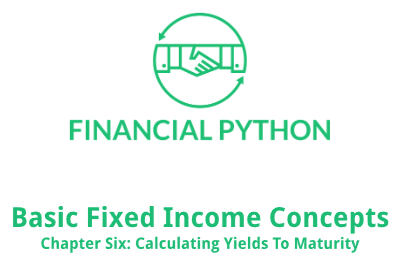

***Roadmap Of Financial And Python Concepts***
<ul type='dot'>
<li><font size=5>Yield To Maturity</li>

<ul tupe='dot'>
  <li>Defining Yield To Maturity.</li>
  <li>Yield To Maturity Is Not A Holding Period Rate Of Retrun.</li>
  <li>How To Calculate Yield To Maturity.</li>
  </ul>
<li>New Functions</li>  
<ul tupe='dot'>
  <li>Calculating The Present Value Of A Bond: the bond_pv() Function</li>
  <li>Iterating To Find The Yield To Maturity: single_newton_raphson() Function</li>
  <li>A Function That Returns Yield To Maturity: calc_ytm()</li>
</ul>

<li>Compare Yields To Maturity And Par Yields</li>
<ul tupe='dot'>
  <li>Create A Pandas DataFrame Of Side-By-Side Summary Statistics Of Par Yieds And Yields To Maturity</li>
  <li>A Graph Of Differences Of Par Yields And Yields To Maturity</li>
</ul>



##***What Is The Yield To Maturity And Why Does It Matter?***
####The yield to maturity of a bond is the single discount rate that equates the discounted value of the bond's cash flows to its value:


#$$Bond = \sum_{i=1}^{N}Cash\ Flow_{t_{i}}\times e^{-y\times t_{i}}.$$
<br>

The yield to maturity is $y$ , $t_i$ is the time in years, $Cash\,Flow_{t_i}$ is a coupon or principal payment, and $N$ is the number of cash flows.  The yield tomaturity of a bond making a single payment at maturity equals:

<br>

$$\Large P(t) = e^{-y\times t}\times Cash\ Flow_t$$

$$\Large y=\frac{-ln(\frac{P(t)}{Cash\ Flow_t})}{t}$$
<br>

####You might be tempted to conclude that the yield to maturity is the internal rate of return you will earn by holding the bond until maturity.  A conclusion that is false, but is often a useful approximation.  To see the problem consider the bond that makes a single payment at maturity.  If the bond is purchased today and held until maturity, the internal rate of return is the yield to maturity.  The same can not be said for a bond with multiple cash flows.  A bond with multiple payments requires a reinvestment of cash flows and the rate of return earned on reinvestment of the cash flows is unlikely to be the yield to maturity.  If you are familiar with the limitations of using the internal rate of return for capital budgeting, you are familiar with the problems of the yield to maturity.

####Having noted the limitation of yield to maturity, it's important to qualify the likely impact.  The prices of bonds reflect the term structure of interest rates and in some fashion incorporate forward rates of interest or reinvestment rates of returns.

##***Preparing The Notebook***
####The only required libraries are NumPy, Pandas, and datetime. A few functions for confirming files, getting bond payment data, and updating the Excel workbook are imported from python_for_finance.

In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime, date
!wget -q -O python_for_finance.py 'https://www.dropbox.com/scl/fi/vsr2m7ab0054e5lusl4zz/\
python_for_finance.py?rlkey=fifbrd4felwihfwrfo40dbrvj&dl=0'
from python_for_finance import confirm_required,bond_pay_data,create_workbook, one_y_axis

##***Confirm Presence Of Required Folder & File***


In [ ]:
# Assign the string 'Basic Concepts Of Fixed Income' to the 'folder' variable.
# The name of a directory or a conceptual grouping for the project
folder='Basic Concepts Of Fixed Income' #Volume name assigned to folder

# Assign the string ' Chapter Four: Bootstrapping The Term Structure' variable.
# This serves as a title or identifier for the specific analysis or notebook
name=' Chapter Four: Bootstrapping The Term Structure'   #Notebook name assigned

# Assign a Google Colab notebook URL to the 'link' variable.
# This provides a direct link to the collaborative environment where the code is run.
link='https://colab.research.google.com/drive/1bkNzdUkNSOIrAeDacsXnJLbc9qLTWWLq?usp=sharing'

# Assign the string 'Bond Price Data.xlsx' to the 'file' variable.
# This is the name of the data file that will be loaded or used in the analysis
file='Bond Price Data.xlsx'

# Call the 'confirm_required' function, which was imported from the custom module.
# This function the provided folder, name, link, and file variables to
# set up the working environment, verify file existence, or display header information for the notebook.
confirm_required(folder=folder,file=file,
            name=name,link=link)

Mounted at /content/drive


##***Basic Concepts Of Fixed Income & Bond Price Data.xlsx     Already Exists on your google drive***

##***Get Data From Bond Price Data.xlsx Workbook***

###The estimated zero prices and the Fidelity bond data is accessed from the Excel workbook.  The URL address points to the workbook on a Google drive.  Estimates of zero prices are in the sheet 'Zero Price Estimates' and the Fidelity bond data is in the worksheet 'Fidelity Data'.

####The Pandas method read_excel() converts the two worksheets to the DataFrames 'zero_prices' and 'bond_data'.

```
url='/content/drive/MyDrive/'+folder+'/'+file
zero_prices=pd.read_excel(url,index_col=0,sheet_name='Zero Price Estimates')
bond_data=pd.read_excel(url,index_col=0,sheet_name='Fidelity Data')
```



In [ ]:
#Construct the full file path.
url = '/content/drive/MyDrive/' + folder + '/' + file
print(f"Attempting to load data from {url}")

#Load the data from Excel, using the first column as the index.
try:
  zero_prices= pd.read_excel(url, index_col=0,sheet_name='Zero Price Estimates')
  bond_data = pd.read_excel(url, index_col=0)

except FileNotFoundError:
  print("\nERROR: File not found.")
  print("Please check that the 'folder' and 'file' variables are spelled correctly\n\
and that the file exists in that location.")

Attempting to load data from /content/drive/MyDrive/Basic Concepts Of Fixed Income/Bond Price Data.xlsx


##***Calculating The Yield To Maturity***
####For bonds making a single payment, the yield to maturity is calculated as minus the natural log of the ratio of the bond price and the cash flow divided by the maturity date.  For a bond with multiple payments, there is no analytical solution. A search procedure is required. The Newton-Raphson technique is a common search procedure and well suited for calculating the yield to maturity,  

####The technique linearizes functions as first-order Taylor series expansions.  If a function is differentiable, the value of the function is approximated with the linear function:

$$f(x+\Delta x) \thickapprox f(x) +\frac{df(x)}{dx}\times\Delta x$$

####where $\frac{df(x)}{dx}$ is the first derivative of the function.    As $\Delta x$ goes to zero the error of the approximation goes to zero.


##***The bond_pv_function() Calculates The Present Value And Derivative***
####To calculate a bond's yield to maturity, a function must first be developed to determine its present value and the derivative of its present value relative to a given discount rate. The present value of a sequence of cash payoffs is:
<br>
$$\large  Present\ Value= \sum_{i=1}^{N}Cash\ Flow_{t_i}\times e^{-rate_i\times t_i}$$
<br>

####The partial derivative of the present value function for the single rate at $t_i$ is:
<br>
$$ \frac{\partial Present\ Value}{\partial rate_{t_i}}= t_i\times Cash\ Flow_{t_i}\times e^{-rate_{t_i}\times t_i}$$

####Because the yield to maturity is the single rate $y$ for all payment dates, the derivative with respect to $y$ equals the sum at all the dates:
<br>
$$\frac{\partial Present\ Value}{\partial y}=\sum_{i=1}^{N} t_i\times Cash\ Flow_{t_i}\times e^{-y\times t_i}$$
<br>

####The `bond_pv_function` accepts three arguments:


*   ***`rates`: This can be a single numerical value (e.g., 0.05), a list, a tuple, or an array (e.g., `[0.04, 0.05]`).***
*   ***`data_dict`: This dictionary contains payment dates and amounts, as returned by the `pay_data` function. It can also optionally include the settlement date.  The keys of the dictionary are 'paydata' and 'settlement'.***
*   ***settlement`: If not specified within `data_dict`, this argument defaults to the current date.***



```
def bond_pv(rates,data_dict=None,settlement=None):
```




####Before execution, the function validates the arguments.



*   ***Rates type check: The NumPy function `.issubdtype(rates, np.number)` confirms that each element in `rates` is a number.***



```
  if not np.issubdtype(rates.dtype, np.number):
    raise TypeError("rates includes not numeric data")
```

*   ***`pay_data` validation: Confirm pay_data exists and that both elements of `pay_data` are verified as NumPy arrays of equal size.***

```
  if 'pay_data' not in data_dict:
    raise KeyError('Pay data from bond_pay_data not included in data_dict')
  pay_data=data_dict['pay_data']
  if False in [isinstance(pay_data[0],np.ndarray) or isinstance(pay_data[1],np.ndarray)]:
    raise TypeError("pay_data Not from bond_pay_data")
 if pay_data[0].size != pay_data[1].size:
   raise TypeError("pay_data Not from bond_pay_data")
```
*   ***rates array conformity: The size of the `rates` array is conformed to the size of `pay_data` (payment dates).***

```
 if rates.size<pay_dates.size:
 #If single rates create an array of that single rate
   if rates.size==1:
     rates=np.full(pay_dates.size,rates)
  #If more than one but less then size of pay dates
   else:
     rates=np.append(rates,np.full(pay_dates.size-rates.size,rates[-1]))
```




####Using the NumPy arrays `rates`, `pay_dates`, and `payments`, the present value of each payment is calculated and assigned to the `pv_payments` array. The sum of this `pv_payments` array is the present value of the bond.
<br>

```
  pv_payments=np.exp(-rates*pay_dates)*payments
  value=np.sum(pv_payments)
```
<br>

####At each payment date, the derivative is calculated by multiplying the `pay_dates` array and $\large e$ raised to the power of the product of `rates` and `pay_dates` or the pay dates times the present value factor at those dates. The sum of this array is the derivative of all the bond's payments.
<br>

```
  derivatives_array=pay_dates*np.exp(-rates*pay_dates)
  sum_derivatives=-np.sum(derivatives_array)
  return value,sum_derivatives
```

####The function returns thepresent value of the bond and its derivative with respect to rates.

```
  return value,sum_derivatives
```

In [ ]:
def bond_pv(rates, data_dict=None, settlement=None):
  '''
  Returns the present value of a bond and its derivative with respect to rates.

  Args:
      rates (float or np.ndarray): A single discount rate or a NumPy array of rates.
      data_dict: required pay_data (tuple): A tuple containing two NumPy arrays:
                        1. An array of payment dates (datetime.date objects).
                        2. An array of corresponding payment amounts.
                        It's expected this is generated from a separate function like `bond_pay_data`.
      settlement (datetime.date, optional): The date for which the valuation is being performed.
                                            Defaults to the current date if not in data_dict.

  Returns:
      tuple: A tuple containing:
             - The total present value of the bond (float).
             - The sum of the derivatives of the present value with respect to the rates (float).
  '''
  # Import necessary libraries
  import numpy as np
  from datetime import date
  if 'settlement' in data_dict:
    settlement=data_dict['settlement']

  # Set the settlement date to today if it's not provided
  if settlement is None:
    settlement=date.today()

  # --- Input Validation ---
  rates=np.array(rates)
  if not np.issubdtype(rates.dtype, np.number):
    raise TypeError("rates includes not numeric data")

  # Check if pay_data in data_dict
  if 'pay_data' not in data_dict:
    raise KeyError('Pay data from bond_pay_data not included in data_dict')
  pay_data=data_dict['pay_data']

  # Check if pay_data is structured correctly with two NumPy arrays
  if False in [isinstance(pay_data[0],np.ndarray) or isinstance(pay_data[1],np.ndarray)]:
    raise TypeError("pay_data Not from bond_pay_data")

  # Ensure the dates and payments arrays have the same number of elements
  if pay_data[0].size != pay_data[1].size:
    raise TypeError("pay_data Not from bond_pay_data")

  # Calculate the time to each payment in years from the settlement date
  pay_dates=np.array([value.days/365 for value in (pay_data[0]-settlement)])

  # Ensure there is a discount rate for every payment date
  if rates.size<pay_dates.size:
  #If single rate create an array of that single rate
    if rates.size==1:
      rates=np.full(pay_dates.size,rates)
   #If more than one but less then size of pay dates
    else:
      rates=np.append(rate,np.full(pay_dates.size-rate.size,rates[-1]))

  #Calculate pv of each payment and sum to get value
  pv_payments=pay_data[1]*np.exp(-rates*pay_dates)
  value=np.sum(pv_payments)

  #Derivatives for each payment
  derivatives_array=-pay_dates*pv_payments

  #Derivative for all payments
  sum_derivatives=np.sum(derivatives_array)
  return value,sum_derivatives

##***Testing The bond_pv_function()***
####The bond_pv() function is demonstrated with the longest maturity bond of the bond_data DataFrame (January 31$^{st}$ 2030). The bond is priced with two assumptions about the rates array.

   
1.   ***A single rate equal to the bond's par yield.***

2.   ***Multiple rates equal to the spot rates derived from the zero prices on the bond's payment dates.***


####Both estimates are compared to the bond's dirty price (the bid-ask average plus accrued interest). The single par yield rate deviates from the actual price by approximately 22 basis points; the present value calculated using implied spot rates is accurate to five decimal places.

In [ ]:
# Define the settlement date for the valuation. All cash flows will be discounted back to this date.
settlement=date(2025,1,21)

# Select the specific bond to be analyzed from a pandas DataFrame named 'bond_data'.
us_2030_1_31 = bond_data.iloc[-1]

# The bond's key characteristics: its coupon rate and maturity date.
coupon = us_2030_1_31['Coupon']
par_yield=us_2030_1_31['Par Yield']
maturity = date(2030, 1, 31)

# Generate the bond's future cash flows (payment dates and amounts) using a helper function.
pay_data = bond_pay_data(maturity, coupon, settlement=settlement)
data_dict={'settlement':settlement,'pay_data':pay_data}
# Calculate Present Value (PV) by discounting its cash flows single par yield rate
par_yield_pv, derivative = bond_pv(par_yield, data_dict)

# First, find the zero-coupon prices that correspond to our bond's payment dates.
zero_locations = zero_prices.index.get_indexer(pay_data[0])
zeros = zero_prices['Zero Prices'].iloc[zero_locations]

# Calculate continuously compounded spot rate using the formula rate = -ln(Price) / time
pay_dates_years = np.array([value.days / 365 for value in (pay_data[0] - settlement)])
rates = -np.log(zeros.to_numpy()) / pay_dates_years

# Calculate Present Value (PV) by discounting its cash flows (`pay_data`)spot rates
zero_pv, derivative = bond_pv(rates, data_dict)

# Calculate the bond's actual market price, also known as the "dirty price".
dirty_price=(us_2030_1_31['Price Bid']+us_2030_1_31['Price Ask'])/2+us_2030_1_31['Accrued']
# Display the three final values for comparison.
print(f"Par Yield: {par_yield_pv:,.5f}....Dirty Price: {dirty_price:,.5f}....Zero Prices: {zero_pv:,.5f}")

Par Yield: 97.43963....Dirty Price: 97.65739....Zero Prices: 97.65739


###***Your Turn To Estimate The Present Value Of A Bond***


1.   ***Use the bond that maturity on February 28$^{th} 2027 with a coupon of 1.125.***
2.   ***Use the single rate 4.20% for the rate argument.***
3.   ***Use the implied spot rates for the bond's payment dates.***



##***Estimating The Yield To Maturity Of The January 31$^{st}$ 2030 Bond***

####The Newton-Raphson technique finds a function's roots by iterating through successive first-order Taylor series expansions. In this case, the function represents the disparity between the bond's present value at a specific yield and its dirty price.


###***The single_newton_raphson() Function***

####The function `single_newton_raphson()` is defined with two required arguments and four optional arguments with default values. The required arguments are the `target` value and the `function` to be solved. The optional arguments are: `data` (any data passed to the function being solved), `num_attempts` (number of attempted solutions), `guess` (an initial guess), and `tolerance` (how close the final value is to zero). The `tolerance` defaults to 0.00001 or a tenth of a cent on one hundred dollars.



```
def single_newton_raphson(target_value, linear, data=None, num_attempts=50,
                         guess=0.0001, tolerance=1e-5):
   """
   Finds a root of a function using the Newton-Raphson method.


   Args:
       target_value (float): The target value we want the function to return.
       function (callable): A function that takes a guess and optional data,
                            and returns a tuple (value, derivative).
       data (any, optional): Additional data to pass to the function.
       num_attempts (int): Maximum number of iterations.
       guess (float): Initial guess for the root.
       tolerance (float): The desired precision of the result.


   Returns:
       tuple: (number_of_guesses, final_guess, final_value)
       str: An error message if no solution is found.

  '''
   for num_guesses in range(number_attempts):
       value, derivative = function(guess, data)
      
       # Calculate how far off we are from the target
       error = value - target_value
      
       # Check for convergence
       if abs(error) <= tolerance:
           return num_guesses, guess, value
      
       # Avoid division by zero
       if np.isclose(derivative, 0):
           return "No solution found: derivative is zero."


       # Newton-Raphson update step
       # We use value - target_value (the error) as f(x)
       # The standard formula is x_n+1 = x_n - f(x_n)/f'(x_n)
       guess = guess - error / derivative
      
   return "No solution found after {} attempts.".format(number_attempts)

```

####The bond_pv() function returns interim values and derivatives for each iteration. An error is calculated at each iteration, followed by the computation of a new guess. The NumPy function `isclose()` is used to check if a derivative is zero for computational purposes. The iteration proceeds as long as the absolute error exceeds the tolerance value, the number of guesses does not surpass the `num_attempts` value, and the derivative isn't determined to be zero.$^{1}$



---
#####$^{1}$ If x includes more than one variable, the solution requires the definition of the partial derivatives with respect to each variable- the so-called Jacobin matrix.  With a single variable, dividing by the derivative achieves the same result.


In [ ]:
def single_newton_raphson(target_value, function=None, data=None, num_attempts=50,
                          guess=0.0001, tolerance=1e-5):
    """
    Finds a root of a function using the Newton-Raphson method.

    Args:
        target_value (float): The target value we want the function to return.
        function (callable): A function that takes a guess and optional data,
                             and returns a tuple (value, derivative).
        data (any, optional): Additional data to pass to the function.
        num_attempts (int): Maximum number of iterations.
        guess (float): Initial guess for the root.
        tolerance (float): The desired precision of the result.

    Returns:
        tuple: (number_of_guesses, final_guess, final_value)
        str: An error message if no solution is found.
    """
    if function is None:
      raise TypeError("function must be specified")
    import numpy as np
    num_guesses = 0

    for num_guesses in range(num_attempts):
        value, derivative = function(guess, data)

        # Calculate how far off we are from the target
        error = value - target_value

        # Check for convergence
        if abs(error) <= tolerance:
            return num_guesses, guess, value

        # Avoid division by zero
        if np.isclose(derivative, 0):
            print("No solution found: derivative is zero.")
            return num_guesses+1, guess, value

        # Newton-Raphson update step
        # We use value - target_value (the error) as f(x)
        # The standard formula is x_n+1 = x_n - f(x_n)/f'(x_n)
        guess = guess - error / derivative
    print("No solution found after {} attempts.".format(num_attempts))
    return num_guesses+1, guess, value

###***Calculating The January 31$^{st}$ 2030 Bond's Yield To Maturity With The single_newton_raphson() Function.***
####The arguments are assigned.



*   ***target assigned dirty price of the bond: dirty_price***
*   ***function=bond_pv***
*   ***data={<font color=red>'settlement'</font>:<font color=green>settlement</font><font size=4> ,</font> <font color=red>'pay_data'</font>::<font color=green>pay_data</font>}***
*   ***num_attempts=50 default value***
*   ***guess=par_yield***
*   ***tolerance=0.00001 default value***


In [ ]:
number_iterations,final_result,final_value=single_newton_raphson(dirty_price,
                                                                 function=bond_pv,
                                                                 data=data_dict,
                                                                 guess=par_yield)
print(f'Inital Guess: {par_yield:,.5f}')
print(f'Final Guess:  {final_result:,.5f}')
print(f'Dirty Price (bid/ask +Accried):   {dirty_price:,.5f}')
print(f'Value Of Function At Final Guess: {final_value:,.5f}')
print(f'Number Of Guesses: {number_iterations}')

Inital Guess: 0.04394
Final Guess:  0.04345
Dirty Price (bid/ask +Accried):   97.65739
Value Of Function At Final Guess: 97.65739
Number Of Guesses: 2


##***The Function calc_ytm()***
####The `calc_ytm()` function utilizes the `bond_pay_data()` function to retrieve payment dates and amounts. This information, combined with the settlement date, populates the `data_dict` dictionary. Subsequently, the Newton-Raphson technique feeds this data to the `bond_pv()` function, enabling iterative refinements of the yield to maturity estimates.

In [ ]:
def calc_ytm(price,maturity,coupon,guess=0.01,settlement=None):
  """
  Calculates the Yield to Maturity (YTM) for a bond.

  YTM is the total annualized return an investor can expect if they hold the bond
  until it matures. This function finds the discount rate that equates the
  present value of the bond's future cash flows to its current market price
  using the Newton-Raphson numerical method.

  Args:
    price (float): The current market price of the bond.
    maturity (date): The bond's maturity date.
    coupon (float): The annual coupon rate of the bond (e.g., 0.05 for 5%).
    guess (float, optional): An initial guess for the YTM. Defaults to 0.01 (1%).
                           A good guess can speed up the calculation.
    settlement (date, optional): The date the bond is purchased.
                                 Defaults to the current date.

  Returns:
    float: The calculated Yield to Maturity (YTM) of the bond.
  """
  from datetime import date
  import numpy as np

  # If the initial guess is not a number (NaN), reset it to a default value.
  if np.isnan(guess):
    guess=0.01

  # If no settlement date is provided, use today's date.
  if settlement is None:
    settlement=date.today()

  # Call bond_pay_data() to get the schedule of all future payments
  pay_data=bond_pay_data(maturity,coupon,settlement=settlement)

  # Create a dictionary to pass necessary data to the bond_pv function
  data_dict={'settlement':settlement,'pay_data':pay_data}

  #Newton-Raphson technique passes data to bond_pv to update estimates
  number_iterations,final_result,final_value=single_newton_raphson(price,
                                                                  function=bond_pv,
                                                                  data=data_dict,
                                                                  guess=guess)

  #Failure to converge causes alert, but final shows value at maximum tries
  return final_result

###***Your Turn To Estimate The Yield To Maturity Of A Bond***


1.   ***Use the bond that maturity on February 28$^{th} 2027 with a coupon of 1.125.***
2.   ***Assign 4.259% to guess.***

3.   ***Do not include 'settlement' as a key to data_dict or as an argument of calc_ytm().***
4.   ***Do not include 'settlement' as a key to data_dict but assign January 21$^{st}$ 2025 as the argument for calc_ytm().***

5.   ***Why do the two estimates of yield to maturity differ?***



##***Adding Yield To Maturity To bond_data***
####The Pandas `iterrows()` method offers a convenient and transparent way to update `bond_data` with yields to maturity. This method iterates through the rows of the DataFrame, returning values as a series that are arguments of calc_ytm(). The yields to maturity are then assigned to the 'Yield To Maturity' column in `bond_data`.

In [ ]:
bond_data['Yield To Maturity'] = [calc_ytm(price=(row['Price Bid']+row['Price Ask'])/2
                                           +row['Accrued'],
                                           maturity=row.name,
                                           coupon=row['Coupon'],
                                           guess=row['Par Yield'],
                                           settlement=settlement)
                                  for index, row in bond_data.iterrows()]

In [ ]:
bond_data

,Description,Coupon,Price Bid,Price Ask,Bid Size,Ask Size,Accrued,Par Yield,Yield To Maturity
Maturity Date,,,,,,,,,
2025-01-28,UNITED STATES TREAS BILLS ZERO CPN 0.000...,0.000,99.929,99.930,100000,100000,0.000000,0.037763,0.036774
2025-01-30,UNITED STATES TREAS BILLS ZERO CPN 0.000...,0.000,99.906,99.907,40000,40000,0.000000,0.038976,0.037937
2025-01-31,UNITED STATES TREAS SER U-2025 1.3750...,1.375,99.921,99.934,60000,60000,0.650136,0.041852,0.039848
2025-01-31,UNITED STATES TREAS SER AW-2025 4.1250...,4.125,99.988,99.997,60000,60000,1.950408,0.041852,0.042794
2025-01-31,UNITED STATES TREAS SER G-2025 2.5000...,2.500,99.953,99.965,60000,60000,1.182065,0.041852,0.039291
...,...,...,...,...,...,...,...,...,...
2029-11-30,UNITED STATES TREAS SER AG-2029 4.1250...,4.125,98.910,98.914,100000,100000,0.589286,0.043822,0.043250
2029-11-30,UNITED STATES TREAS SER S-2029 3.8750...,3.875,97.763,97.782,40000,40000,0.553571,0.043822,0.043379
2029-12-31,UNITED STATES TREAS SER T-2029 3.8750...,3.875,97.734,97.738,65000,65000,0.224793,0.043832,0.043389


##***Comparing Par Yields And Yields To Maturity***
####The yield to maturity equates the present value of a bond's payments and its price.

####The par yield is the coupon rate for a given maturity that makes the present value of coupon and principal payments discounted at spot prices equal to the par value.

####Although yield to maturity and par yield are related, they are not identical.

####The Pandas method describe() is used to compare the par yields and yields to maturity of the 304 Fidelity bonds.  The method returns a number of summary statistics for both series.  A Pandas DataFrame is created from a dictionary, mapping 'Par Yield' and 'Yield To Maturity' to their respective `describe()` statistics, creating a convenient side-by-side comparison.$^{1}$

---
#####$^{1}$ For three zero coupon bonds inferred payment dates are unmatched with zero price estimates and those par yields are assigned the NumPy  value nan.

In [ ]:
pd.DataFrame({'Par Yield':bond_data['Par Yield'].describe(),
              'Yield To Maturity':bond_data['Yield To Maturity'].describe()})

,Par Yield,Yield To Maturity
count,301.000000,304.000000
mean,0.042680,0.042041
std,0.002508,0.002705
min,0.013481,0.013546
25%,0.042520,0.041992
50%,0.042868,0.042292
75%,0.043478,0.043028
max,0.047699,0.046420


##***The Plot Of Differenes In Yields Reveals Related But Difference Series***
####The `one_y_axis()` function plots the difference between par yields and yield to maturity. Estimates for three zero-coupon bonds were dropped using Pandas' `dropna()` method because their inferred coupon payment dates did not align with the zero estimates.

####This plot, saved in the Google Drive folder 'Basic Concepts Of Fixed Income', uses maturity dates converted to years, calculated from the settlement date of January 21$^{st}$ 2025.


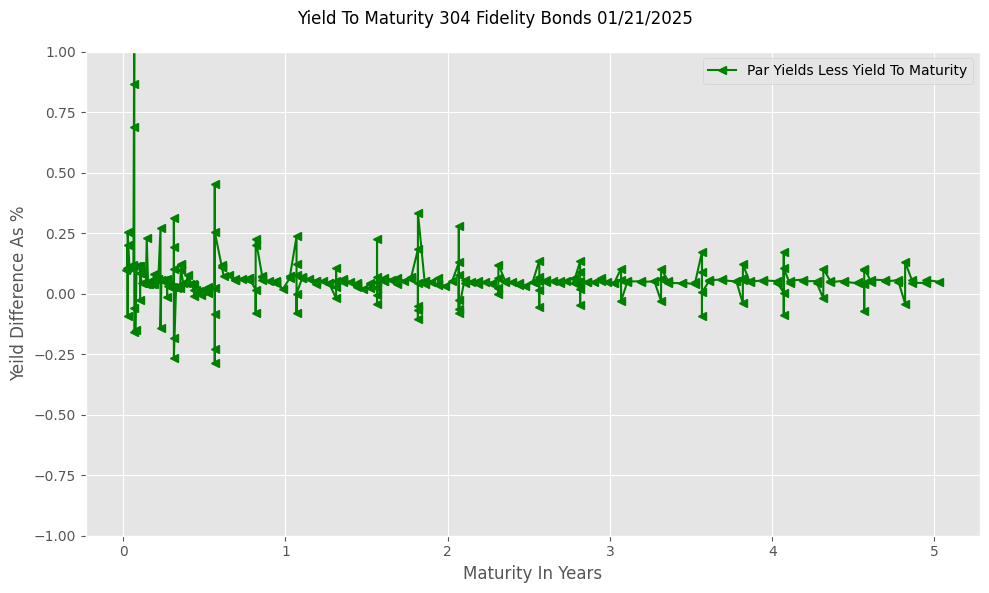

In [ ]:
# Calculate the time to maturity in years for each data point (drop nan par yields)
years=[(date-datetime_settlement).days/365 for date in bond_data.dropna().index]

# Initialize a dictionary to hold plot-saving configurations.
save_config={}
string_date='01/21/2025'

# Set the x-axis and y-axis data for the plot.
#Maturity relative to settlement data
xaxis=years
#y-axis data (drop nan values of par yield)
data=[(bond_data['Par Yield']*100-bond_data['Yield To Maturity']*100).dropna()]

# Attempt to extract the plot title from the file name.
try:
    title = save_config['File Name'][:-4]
#'File' key not found or string is too short), set a default title.
except:
    title = 'Add A Title'

# Define labels for the data series, y-axis, and x-axis.
series=['Par Yields Less Yield To Maturity']
ylabel='Yeild Difference As %'
xlabel='Maturity In Years'

# Set plot aesthetics: marker styles, y-axis limits, figure size, and color.
markers='<'
ylim=[-1,1.0]
size=(10,6)
#Color is green
colors='g'

# Call the plotting function with all the prepared data and configurations
one_y_axis(xaxis,data,title_string,series,xlabel,ylabel,markers,size,ylim,
           save_config=save_config,colors=colors)

##***Plot The Bonds' Yield To Against Their Maturity Date In Years***
####The yield to maturity of the 304 Fidelity bonds is plotted using the function `one_y_axis()`. This plot is saved in the Google Drive folder 'Basic Concepts Of Fixed Income'. The maturity dates were converted to years, calculated from the settlement date of January 21$^{st}$ 2025.

####Apart from a handful of coupon bond, yields to maturity are generally around 4%.


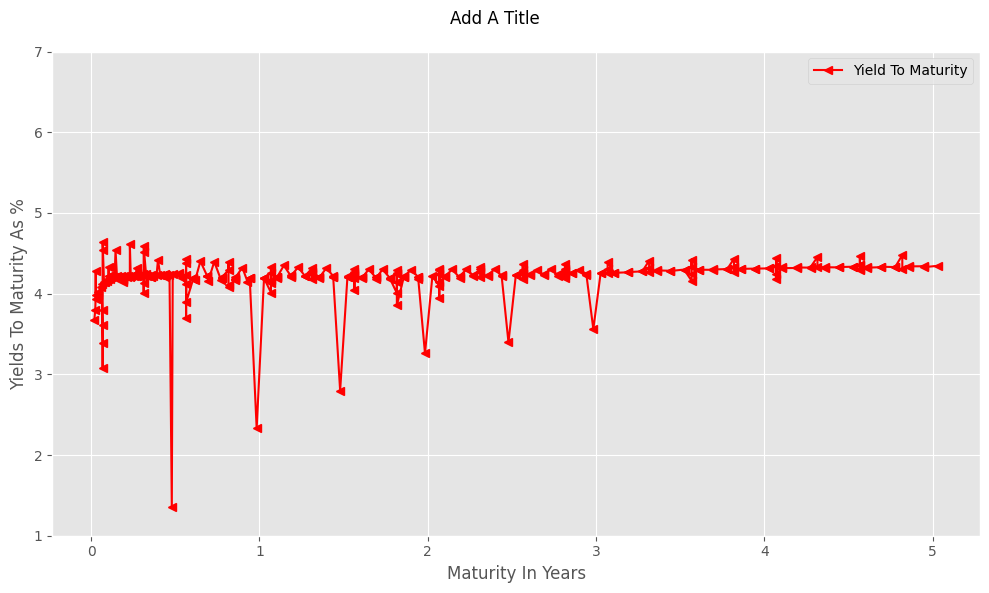

In [ ]:
# Calculate the time to maturity in years for each data point
years=[(date-datetime_settlement).days/365 for date in bond_data.index]

# Initialize a dictionary to hold plot-saving configurations.
save_config={}
string_date='01/21/2025'

# Set the x-axis and y-axis data for the plot.
#Maturity relative to settlement data
xaxis=years
data=[bond_data['Yield To Maturity']*100]

# Define the file name and folder for the saved plot.
save_config['File']='Yield To Maturity 304 Fidelity Bonds '+string_date+'.pdf'
save_config['Folder']=folder

# Attempt to extract the plot title from the file name.
try:
    title = save_config['File Name'][:-4]
#'File' key not found or string is too short), set a default title.
except:
    title = 'Add A Title'

# Define labels for the data series, y-axis, and x-axis.
title_string=save_config['File'][:-4]
series=['Yield To Maturity']
ylabel='Yields To Maturity As %'
xlabel='Maturity In Years'

# Set plot aesthetics: marker styles, y-axis limits, figure size, and color.
markers='<'
ylim=[1,7]
size=(10,6)
# Define colors as red
colors='r'

# Call the plotting function with all the prepared data and configurations
one_y_axis(xaxis, data, title, series, xlabel, ylabel, markers, size, ylim,
           save_config=save_config,colors=colors)

##***Update Fidelity Data With Yield To Maturity Sheet Of Bond Data.xlsx Workbook.***
####The function create_workbook() converts the DataFrame fixed_data into an Excel workbook. The function's arguments are the sheet name, the DataFrame name, and the file path, and it has no default values.

####The function is imported from the 'python_for_finance' module. The path is assigned the concatenation of the location in the notebook's files, the folder, and the file_name. If the google drive is attached, the location in the notebook's files is '/content/drive/MyDrive'.  Otherwise, the location is <font color=#4169E1>/content'</font>.

```
import os
file_name='Bond Data.xlsx'
if os.path.exists('/content/drive/MyDrive') is True:
  path='/content/drive/MyDrive/'+folder+'/'+file_name
else: path='/content/'+file_name

```
####The arguments of the create_workbook() are the sheet name (Fidelity Data), the DataFrame name (fixed_data), and the path.


```
sheet_name='Fidelity Data'
create_workbook(sheet_name,bond_data,path)
```


In [ ]:
from python_for_finance import create_workbook
import os
file_name='Bond Price Data.xlsx'
if os.path.exists('/content/drive/MyDrive') is True:
  path='/content/drive/MyDrive/'+folder+'/'+file_name
else: path='/content/'+file_name
sheet_name='Fidelity Data'
create_workbook(sheet_name,bond_data,path)